<a href="https://colab.research.google.com/github/ElenaMakarova91/skillfactory_rds_module3/blob/main/module_3__%D0%9E_%D0%B2%D0%BA%D1%83%D1%81%D0%BD%D0%BE%D0%B9_%D0%B8_%D0%B7%D0%B4%D0%BE%D1%80%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D0%B8%D1%89%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Загрузка Pandas и очистка данных**

In [ ]:
import numpy as np  # для работы с массивами
import pandas as pd  # для работы DataFrame
import seaborn as sns  # библиотека для визуализации статистических данных
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели
from sklearn.model_selection import train_test_split # специальный инструмент для разбивки  
import matplotlib.pyplot as plt  # для построения графиков
import re  # для регулярных выражений
from ast import literal_eval  # для преобразования списков


In [ ]:
# для распознования тональности отзывов
import textblob
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = './drive/My Drive/Colab Notebooks/skillfactory/module_3'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv(path+'/main_task_new.csv')

#Первоначальная версия датасета состоит из десяти столбцов, содержащих следующую информацию:


* *Restaurant_id* — идентификационный номер ресторана / сети ресторанов;
* *City* — город, в котором находится ресторан;
* *Cuisine Styl*e — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;
* *Ranking* — место, которое занимает данный ресторан среди всех ресторанов своего города;
* *Rating* — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* *Price Range* — диапазон цен в ресторане;
* *Number of Reviews* — количество отзывов о ресторане;
* *Reviews* — данные о двух отзывах, которые отображаются на сайте ресторана;
* *URL_TA* — URL страницы ресторана на TripAdvisor;
* *ID_TA* — идентификатор ресторана в базе данных TripAdvisor.

In [ ]:
df.head(1)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643


In [ ]:
#переименовываем колонки для удобства
df.columns = ['id', 'city', 'cuisine', 'rank', 'rating', 'price', 'number_reviews', 'reviews', 'url', 'ID_TA']

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              40000 non-null  object 
 1   city            40000 non-null  object 
 2   cuisine         30717 non-null  object 
 3   rank            40000 non-null  float64
 4   rating          40000 non-null  float64
 5   price           26114 non-null  object 
 6   number_reviews  37457 non-null  float64
 7   reviews         40000 non-null  object 
 8   url             40000 non-null  object 
 9   ID_TA           40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [ ]:
df.describe()

,rank,rating,number_reviews
count,40000.000000,40000.000000,37457.000000
mean,3676.028525,3.993037,124.825480
std,3708.749567,0.668417,295.666352
min,1.000000,1.000000,2.000000
25%,973.000000,3.500000,9.000000
50%,2285.000000,4.000000,33.000000
75%,5260.000000,4.500000,115.000000
max,16444.000000,5.000000,9660.000000


In [ ]:
df.nunique(dropna=False)  # уникальносить признаков

id                11909
city                 31
cuisine            9008
rank              11936
rating                9
price                 4
number_reviews     1460
reviews           33516
url               39980
ID_TA             39980
dtype: int64

для корректной работы все данные в датафрейме, который вы будете использовать при обучении модели, должны быть в форматах int или float. Есть и ещё одно жёсткое ограничение: в столбцах не должно быть None-значений. В реальных проектах в индустрии используются разные подходы к работе с None-значениями. Если позволяют условия, то строки, содержащие неполные данные, просто удаляют из датасета. Однако в задачах по машинному обучению эта стратегия не используется никогда, потому что настоящие герои никогда не ищут лёгких путей :) Вместо каждого NaN вам нужно будет вычислить и поместить в ячейку максимально близкое к реальности значение.

# Преобразование данных и очистка данных

✅**На первом этапе** для создания такого датафрейма давайте просто **удалим 
столбцы, содержащие данные типа object**, **и заполним пропущенные значения** (None или NaN) каким-то одним значением (нулём или средним арифметическим) для всего столбца.

## Преобразования столбца **id**

In [ ]:
# посмотрим, есть ли повторяющиеся рестораны
t=df['id'].nunique(dropna=False)
l=len(df['id'])
l-t

28091

In [ ]:
# сгруппируем с одинаковыми id
df_id = df[['id']].value_counts()
df_id

id      
id_633      18
id_871      18
id_227      18
id_436      18
id_430      17
            ..
id_15507     1
id_15508     1
id_8980      1
id_15515     1
id_16316     1
Length: 11909, dtype: int64

In [ ]:
df_id = df_id.to_frame().reset_index()
# добавим столбец с количеством ресторанов в группе
df_id.columns = ['id', 'id_group']
df = df.merge(df_id, how='left', on=['id'])

In [ ]:
df.head(3)

,id,city,cuisine,rank,rating,price,number_reviews,reviews,url,ID_TA,id_group
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,10
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,8


## Преобразования столбца **city**

In [ ]:
# посмотрим сколько пропусков в данном столбце
t=df['city'].isna()
t.sum()

0

In [ ]:
len(df['city'].unique())

31

## Преобразования столбца **cuisine**

In [ ]:
# посмотрим сколько пропусков в данном столбце
t=df['cuisine'].isna()
t.sum()

9283

In [ ]:
df['cuisine']

0                  ['European', 'French', 'International']
1                                                      NaN
2        ['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...
3                                                      NaN
4        ['German', 'Central European', 'Vegetarian Fri...
                               ...                        
39995    ['Italian', 'Vegetarian Friendly', 'Vegan Opti...
39996    ['French', 'American', 'Bar', 'European', 'Veg...
39997                                ['Japanese', 'Sushi']
39998    ['Polish', 'European', 'Eastern European', 'Ce...
39999                                          ['Spanish']
Name: cuisine, Length: 40000, dtype: object

In [ ]:
# видим что данные по cuisine записаны в виде списков

In [ ]:
# заполним пропуски новым значением Unknown, так как предугодать в данном случчае очень сложно
df['cuisine']=df['cuisine'].fillna("['unknown']") 

In [ ]:
# преобразуем строку в список 
df['cuisine'] = df['cuisine'].apply(literal_eval) 

In [ ]:
df['cuisine'].explode().value_counts()

Vegetarian Friendly    11189
European               10060
unknown                 9283
Mediterranean           6277
Italian                 5964
                       ...  
Burmese                    1
Latvian                    1
Xinjiang                   1
Salvadoran                 1
Yunnan                     1
Name: cuisine, Length: 126, dtype: int64

создадим новый признак: количество видов кухонь в ресторане.

In [ ]:
cuisines_len = []
for x in df["cuisine"]:
    cuisines_len.append(len(x))

df["number_of_cuisines"] = cuisines_len

In [ ]:
df.head(2)

,id,city,cuisine,rank,rating,price,number_reviews,reviews,url,ID_TA,id_group,number_of_cuisines
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,3
1,id_1535,Stockholm,[unknown],1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,10,1


In [ ]:
# Среднее количество видов кухонь в ресторане
df['number_of_cuisines'].mean()

2.6224

## Преобразование столбца **rank**

In [ ]:
# посмотрим сколько пропусков в данном столбце
t=df['rank'].isna()
t.sum()

0

In [ ]:
df.groupby(["city"])["rank"].max()

city
Amsterdam      3249.0
Athens         1787.0
Barcelona      7796.0
Berlin         6372.0
Bratislava      889.0
Brussels       3004.0
Budapest       2438.0
Copenhagen     1964.0
Dublin         1960.0
Edinburgh      1766.0
Geneva         1413.0
Hamburg        2736.0
Helsinki       1141.0
Krakow         1244.0
Lisbon         3717.0
Ljubljana       468.0
London        16444.0
Luxembourg      621.0
Lyon           2666.0
Madrid         8809.0
Milan          6275.0
Munich         2763.0
Oporto         1484.0
Oslo           1137.0
Paris         13986.0
Prague         4188.0
Rome           5946.0
Stockholm      2464.0
Vienna         3444.0
Warsaw         2141.0
Zurich         1590.0
Name: rank, dtype: float64

## Преобразование столбца **rating**

In [ ]:
# посмотрим сколько пропусков в данном столбце
t=df['rating'].isna()
t.sum()

0

добавим столбец средний рейтинг в городе ресторана

In [ ]:
mean_rating = []
counter = df.groupby(["city"]).rating.mean()

for i in df["city"]:
    mean_rating.append(counter.get(i))

df["mean_rating_in_city"] = mean_rating

## Преобразования столбца **Price**

In [ ]:
len(df)

40000

In [ ]:
# посмотрим сколько пропусков в данном столбце
t=df['price'].isna()
t.sum()

13886

In [ ]:
df['price'].unique()

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [ ]:
# Посмотрим сколько ресторанов относится к среднему ценовому сегменту
(df['price']=='$$ - $$$').value_counts()

False    21588
True     18412
Name: price, dtype: int64

In [ ]:
# Заменим пропуски из столбца price на их моду:
df['price'] = df['price'].fillna(df['price'].mode()[0])

In [ ]:
# Функция для замены символов в столбце price на целые числа:
def price_level(x):
    if x == "$":
        return 1
    elif x == "$$ - $$$":
        return 2
    else:
        return 3

In [ ]:
# заменим буквы в рейтинге цен на цифры от 1(дешевый) до 3 (дорогой):
df['price'] = df['price'].apply(price_level)

## Преобразования столбца **number_reviews**

In [ ]:
# посмотрим сколько пропусков в данном столбце
t=df['number_reviews'].isna()
t.sum()

2543

In [ ]:
print("Среднее:", df["number_reviews"].mean())
print("Медиана:", df["number_reviews"].median())
print("Максимум:", df["number_reviews"].max())
print("Минимум:", df["number_reviews"].min())
print("Уникальных значений:", df["number_reviews"].nunique())

Среднее: 124.82547988359985
Медиана: 33.0
Максимум: 9660.0
Минимум: 2.0
Уникальных значений: 1459


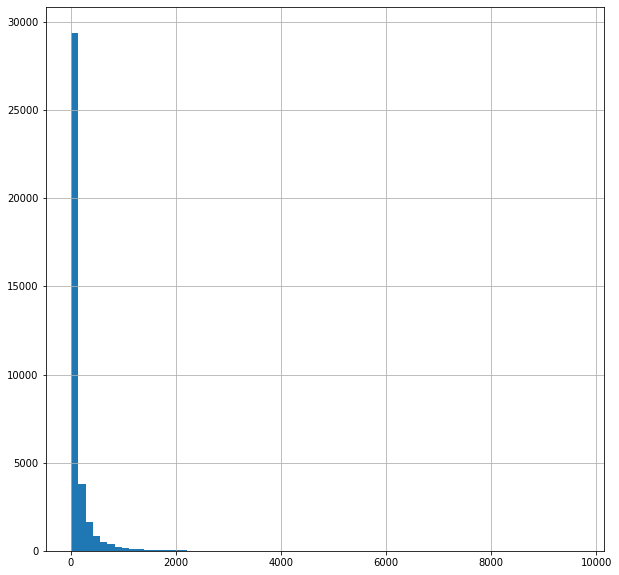

In [ ]:
df["number_reviews"].hist(bins=70) #видим, что присутствуют выбросы.  Форма распределения смещена вправо.

In [ ]:
# убираем пропуски из столбца с отзывами, заполняя их модой по городам  
df['number_reviews'] = df.groupby('city')['number_reviews'].transform(lambda x: x.fillna(x.mode()[0]))

In [ ]:
df.head(4)

,id,city,cuisine,rank,rating,price,number_reviews,reviews,url,ID_TA,id_group,number_of_cuisines,mean_rating_in_city
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,3,3.942414
1,id_1535,Stockholm,[unknown],1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,10,1,3.870122
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,8,7,3.955098
3,id_3456,Berlin,[unknown],3458.0,5.0,2,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,4,1,4.124594


## Преобразования столбца **url**

In [ ]:
# посмотрим сколько пропусков в данном столбце
t=df['url'].isna()
t.sum()

0

## Преобразования столбца **ID_TA**

In [ ]:
# посмотрим сколько пропусков в данном столбце
t=df['ID_TA'].isna()
t.sum()

0

## Преобразования столбца **reviews**

In [ ]:
# посмотрим сколько пропусков в данном столбце
t=df['reviews'].isna()
t.sum()

0

In [ ]:
df['reviews'][1]

"[['Unique cuisine', 'Delicious Nepalese food'], ['07/06/2017', '06/19/2016']]"

видим, что у нас есть 2 отзыва т.е текст и 2 их даты отзыва.
Это очень неудобно.
1)отделим дату.

In [ ]:
# Функция для заполнения столбцов с датами отзывов:
def revdata(row):
    if len(row['reviews_date']) == 2:
        return row['reviews_date'][0], row['reviews_date'][1]
    elif len(row['reviews_date']) == 1:
        return row['reviews_date'][0], np.nan
    else:
        return np.nan,np.nan

In [ ]:
rev_data = re.compile('\'\d+\/\d+\/\d+\'?')
df['reviews_date'] = df['reviews'].apply(rev_data.findall)
df['reviews_date'] = df['reviews_date'].apply(lambda x: sorted([pd.to_datetime(i).date() for i in x]))

добавим два столбца (даты двух отзывов), используя функцию revdata:

In [ ]:
df[['rev_date_1', 'rev_date_2']] = df[['reviews_date']].apply(revdata, axis=1, result_type='expand')

In [ ]:
df.head(2)

,id,city,cuisine,rank,rating,price,number_reviews,reviews,url,ID_TA,id_group,number_of_cuisines,mean_rating_in_city,reviews_date,rev_date_1,rev_date_2
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,3,3.942414,"[2017-11-20, 2017-12-31]",2017-11-20,2017-12-31
1,id_1535,Stockholm,[unknown],1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,10,1,3.870122,"[2016-06-19, 2017-07-06]",2016-06-19,2017-07-06


In [ ]:
# Заполним пропуски модой по группам ресторанов:
df['rev_date_1'] = df.groupby('id_group')['rev_date_1'].\
    transform(lambda x: x.fillna(x.mode()[0]))   

df['rev_date_2'] = df.groupby('id_group')['rev_date_2'].\
    transform(lambda x: x.fillna(x.mode()[0]))

In [ ]:
# Добавим столбец разницы дней между первым и вторым отзывом:
df['date_delta'] = df['rev_date_2'] - df['rev_date_1']
df['date_delta'] = df['date_delta'].dt.days

In [ ]:
df['date_delta'].max()

5009

добавим столбец медиана количества отзывов в городе ремторана

In [ ]:
median_reviews = []
counter = df.groupby(["city"]).number_reviews.median()

for i in df["city"]:
    median_reviews.append(int(counter.get(i)))

df["median_number_of_reviews"] = median_reviews

In [ ]:
# Функция для определения полярности отзыва:
def polar(review):
    return TextBlob(review).sentiment.polarity

In [ ]:
# добавbv столбец с полярностью отзывов
df['sentiment_polarity'] = df['reviews'].apply(polar)
df.head(4) 

,id,city,cuisine,rank,rating,price,number_reviews,reviews,url,ID_TA,id_group,number_of_cuisines,mean_rating_in_city,reviews_date,rev_date_1,rev_date_2,date_delta,median_number_of_reviews,sentiment_polarity
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,3,3.942414,"[2017-11-20, 2017-12-31]",2017-11-20,2017-12-31,41,41,0.700000
1,id_1535,Stockholm,[unknown],1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,10,1,3.870122,"[2016-06-19, 2017-07-06]",2016-06-19,2017-07-06,382,16,0.687500
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,8,7,3.955098,"[2018-01-06, 2018-01-08]",2018-01-06,2018-01-08,2,31,-0.333333
3,id_3456,Berlin,[unknown],3458.0,5.0,2,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,4,1,4.124594,[],2017-11-05,2018-01-07,63,14,0.000000


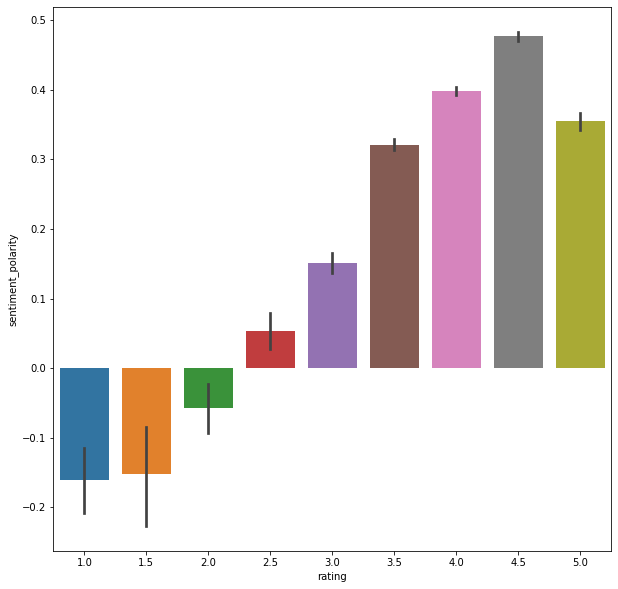

In [ ]:
# построим среднюю полярность для каждого балла рейтинга:
sns.barplot(x='rating', y='sentiment_polarity', data=df) 

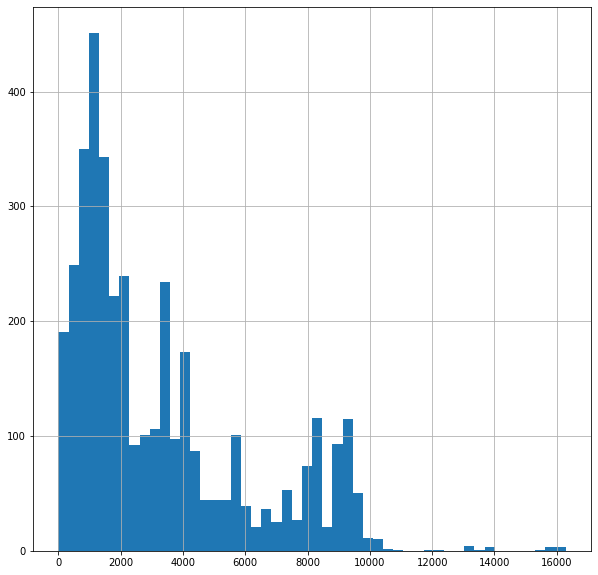

In [ ]:
# Посмотрим распределение целевой переменной относительно признака:
df['rank'][df['rating'] == 5].hist(bins=50)

Распределение похоже на нормальное, но попробуем его улучшить с помощью новых признаков. Для этого создадим столбец с количеством ресторанов в каждом городе

создадим новый столбец количество ресторанов в городе ресторана number_of_restaurants

In [ ]:
df1=df[['city']].value_counts() # группируем данные по гороодам, считаем кол-во ресторанов в каждом городе
df1 = df1.to_frame().reset_index() # преобразуем в ДФ
df1.columns=['city', 'number_of_restaurants'] # прописываем названия столбцов
df = df.merge(df1, how='left', on=['city']) #  добавляем столбец с количеством ресторанов в городе в основной ДФ
df.sample()

,id,city,cuisine,rank,rating,price,number_reviews,reviews,url,ID_TA,id_group,number_of_cuisines,mean_rating_in_city,reviews_date,rev_date_1,rev_date_2,date_delta,median_number_of_reviews,sentiment_polarity,number_of_restaurants
22031,id_1320,Vienna,"[Austrian, Central European, European]",1321.0,4.0,2,29.0,"[['Great bar', 'Cool spot for coctails'], ['09...",/Restaurant_Review-g190454-d7653478-Reviews-If...,d7653478,11,3,4.078045,"[2017-04-30, 2017-09-16]",2017-04-30,2017-09-16,139,18,0.575,1166


In [ ]:
# Добавим новый признак 'delta_ranking_index':
# отнимим от места, которое занимает ресторан в городе, количество ресторанов. потом поделим на количество
df['delta_ranking']=df['number_of_restaurants'] - df['rank']
df['delta_ranking_index'] = df['delta_ranking']/df['number_of_restaurants']
df.head(4)

,id,city,cuisine,rank,rating,price,number_reviews,reviews,url,ID_TA,id_group,number_of_cuisines,mean_rating_in_city,reviews_date,rev_date_1,rev_date_2,date_delta,median_number_of_reviews,sentiment_polarity,number_of_restaurants,delta_ranking,delta_ranking_index
0,id_5569,Paris,"[European, French, International]",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,3,3,3.942414,"[2017-11-20, 2017-12-31]",2017-11-20,2017-12-31,41,41,0.700000,4897,-673.0,-0.137431
1,id_1535,Stockholm,[unknown],1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,10,1,3.870122,"[2016-06-19, 2017-07-06]",2016-06-19,2017-07-06,382,16,0.687500,820,-717.0,-0.874390
2,id_352,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,8,7,3.955098,"[2018-01-06, 2018-01-08]",2018-01-06,2018-01-08,2,31,-0.333333,5757,5404.0,0.938683
3,id_3456,Berlin,[unknown],3458.0,5.0,2,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,4,1,4.124594,[],2017-11-05,2018-01-07,63,14,0.000000,2155,-1303.0,-0.604640


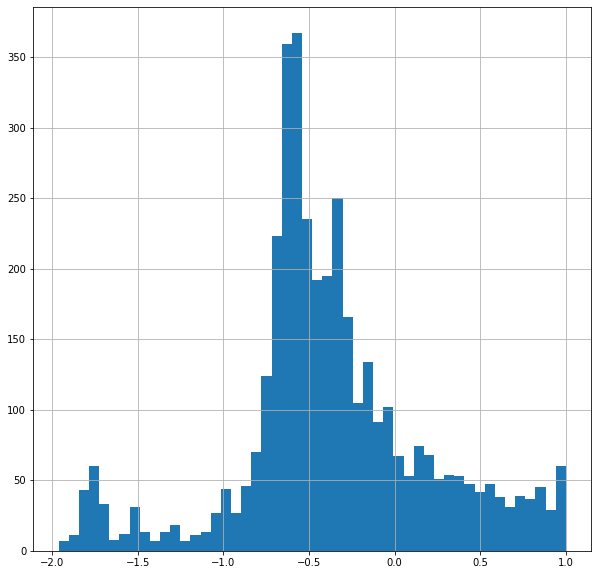

In [ ]:
# Посмотрим распределение целевой переменной относительно признака:
df['delta_ranking_index'][df['rating'] == 5].hist(bins=50)

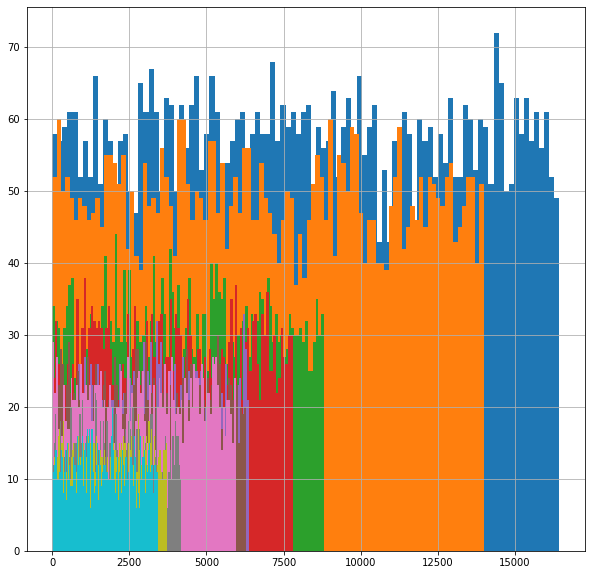

In [ ]:
for x in (df['city'].value_counts())[0:10].index:
    df['rank'][df['city'] == x].hist(bins=100)
plt.show()

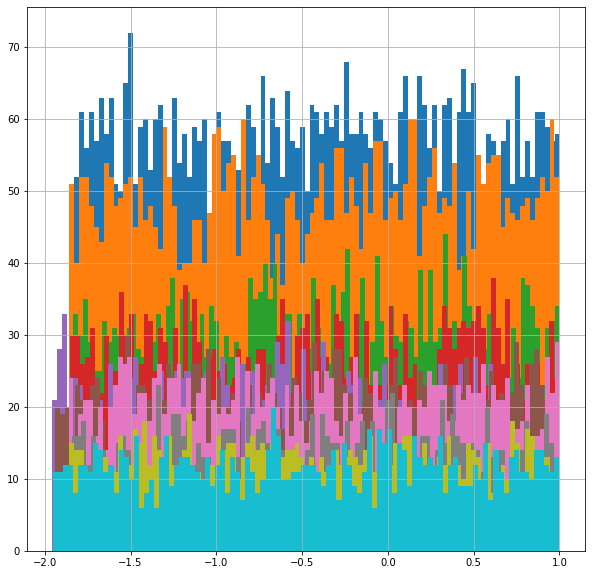

In [ ]:
for x in (df['city'].value_counts())[0:10].index:
    df['delta_ranking_index'][df['city'] == x].hist(bins=100)
plt.show()

In [ ]:
corr = df.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,rank,rating,price,number_reviews,id_group,number_of_cuisines,mean_rating_in_city,date_delta,median_number_of_reviews,sentiment_polarity,number_of_restaurants,delta_ranking,delta_ranking_index
rank,1.00,-0.37,-0.03,-0.22,-0.76,-0.32,-0.25,0.14,0.09,-0.21,0.71,-0.88,-0.55
rating,-0.37,1.00,-0.03,0.03,0.29,0.12,0.17,-0.08,0.05,0.27,-0.06,0.46,0.54
price,-0.03,-0.03,1.00,0.11,0.04,0.00,-0.07,-0.01,-0.05,-0.03,0.01,0.04,0.05
number_reviews,-0.22,0.03,0.11,1.00,0.25,0.41,0.05,-0.15,0.16,0.14,0.03,0.32,0.41
id_group,-0.76,0.29,0.04,0.25,1.00,0.35,0.23,-0.15,-0.12,0.21,-0.59,0.63,0.53
number_of_cuisines,-0.32,0.12,0.00,0.41,0.35,1.00,0.12,-0.25,0.09,0.24,-0.02,0.42,0.54
mean_rating_in_city,-0.25,0.17,-0.07,0.05,0.23,0.12,1.00,-0.03,0.32,0.07,-0.36,0.10,-0.01
date_delta,0.14,-0.08,-0.01,-0.15,-0.15,-0.25,-0.03,1.00,-0.03,-0.01,-0.02,-0.20,-0.25
median_number_of_reviews,0.09,0.05,-0.05,0.16,-0.12,0.09,0.32,-0.03,1.00,0.02,0.13,-0.03,0.01
sentiment_polarity,-0.21,0.27,-0.03,0.14,0.21,0.24,0.07,-0.01,0.02,1.00,0.00,0.29,0.37


In [ ]:
# удалим признаки  'Delta_ranking' поскольку у нас есть новый признак Delta Ranking Index
df=df.drop(['delta_ranking'], axis = 1)

In [ ]:
corr = df.corr()
cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

,rank,rating,price,number_reviews,id_group,number_of_cuisines,mean_rating_in_city,date_delta,median_number_of_reviews,sentiment_polarity,number_of_restaurants,delta_ranking_index
rank,1.00,-0.37,-0.03,-0.22,-0.76,-0.32,-0.25,0.14,0.09,-0.21,0.71,-0.55
rating,-0.37,1.00,-0.03,0.03,0.29,0.12,0.17,-0.08,0.05,0.27,-0.06,0.54
price,-0.03,-0.03,1.00,0.11,0.04,0.00,-0.07,-0.01,-0.05,-0.03,0.01,0.05
number_reviews,-0.22,0.03,0.11,1.00,0.25,0.41,0.05,-0.15,0.16,0.14,0.03,0.41
id_group,-0.76,0.29,0.04,0.25,1.00,0.35,0.23,-0.15,-0.12,0.21,-0.59,0.53
number_of_cuisines,-0.32,0.12,0.00,0.41,0.35,1.00,0.12,-0.25,0.09,0.24,-0.02,0.54
mean_rating_in_city,-0.25,0.17,-0.07,0.05,0.23,0.12,1.00,-0.03,0.32,0.07,-0.36,-0.01
date_delta,0.14,-0.08,-0.01,-0.15,-0.15,-0.25,-0.03,1.00,-0.03,-0.01,-0.02,-0.25
median_number_of_reviews,0.09,0.05,-0.05,0.16,-0.12,0.09,0.32,-0.03,1.00,0.02,0.13,0.01
sentiment_polarity,-0.21,0.27,-0.03,0.14,0.21,0.24,0.07,-0.01,0.02,1.00,0.00,0.37


In [ ]:
# удаляем неколичественные признаки:
df=df.drop(['city', 'cuisine','reviews', 'url', 'ID_TA', 'reviews_date','rev_date_1', 'rev_date_2'], axis = 1)

# 1 РАЗДЕЛЕНИЕ ДАТАФРЕЙМА на части

In [ ]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)  
X = df.drop(['id', 'rating'], axis = 1)  
y = df['rating']  

# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  
      
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# 2 СОЗДАНИЕ, ОБУЧЕНИЕ И ТЕСТИРОВАНИЕ МОДЕЛИ

In [ ]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
      
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  

**Ошибка** возникла при обработке столбца со строковыми значениями. Следовательно, для обучения модели все данные должны быть переданы только в числовом формате. Следовательно, вернёмся и сделаем вначале все преобразования.☝

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.207833


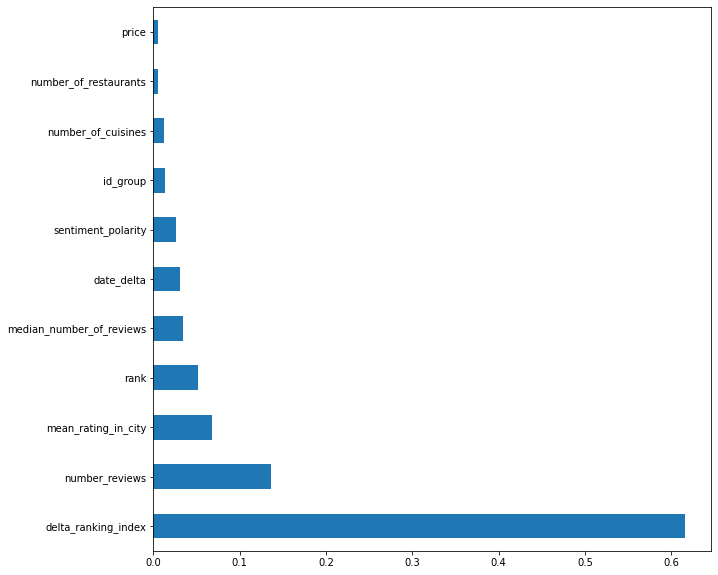

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(regr.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')


In [ ]:
df.head(2)

,id,rank,rating,price,number_reviews,id_group,number_of_cuisines,mean_rating_in_city,date_delta,median_number_of_reviews,sentiment_polarity,number_of_restaurants,delta_ranking_index
0,id_5569,5570.0,3.5,2,194.0,3,3,3.942414,41,41,0.7000,4897,-0.137431
1,id_1535,1537.0,4.0,2,10.0,10,1,3.870122,382,16,0.6875,820,-0.874390


* id — идентификационный номер ресторана / сети ресторанов;
* rank — место, которое занимает данный ресторан среди всех ресторанов своего города;
* rating — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);
* price — диапазон цен в ресторане;
* number_reviews — количество отзывов о ресторане;
* id_group - столбец с количеством ресторанов в группе
* number_of_cuisines - столбец количество видов кухонь в ресторане
* mean_rating_in_city - столбец средний рейтинг в городе ресторана
* date_delta - столбец разницы дней между первым и вторым отзывом
* median_number_of_reviews - столбец медиана количества отзывов в городе ремторана
* sentiment_polarity - столбец с полярностью отзывов
* number_of_restaurants - столбец количество ресторанов в городе ресторана

